<a href="https://colab.research.google.com/github/Sen-R/tutorials-dl/blob/master/notebooks/TensorFlow_Datasets_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Datasets

This notebook provides an overview of how the `tf.data` API can be used to implement data pipelines.

## What is a Dataset?

* A Dataset represents a collection of data (typically data used to train or evaluate a model).
* Datasets can be iterated over, yielding a datastructure such as a python `dict` or `tuple` that represents an individual record.
* A Keras model's `fit` method can consume a dataset directly, with no need to convert into tensors.

## Why use a Dataset?

* Datasets can be transformed into new Datasets by chaining method calls on Dataset objects.
* Common transformations include elementwise transformations applied using `map`, operations to `shuffle` and `batch` Datasets, and buffering and pre-process instructions such as `cache` and `prefetch`.
* In this way, a data pipeline can be defined that can be efficiently, i.e. allowing for optimal use of resources.
* Datasets can then be sharded for distributed training using `tf.distribute`, enabling the use of multi-GPU or TPU acceleration.

## Creating a Dataset

Datasets can be created from many sources.

In [1]:
import tensorflow as tf

### From tensors

In [2]:
X = tf.constant([[1., 2.], [2., 1.], [1., 1.]])
y = tf.constant([[1.], [0.], [1.]])

ds = tf.data.Dataset.from_tensor_slices({"features": X, "labels": y})

print("Dataset contents:")
for record in ds:
    print({k: v.numpy() for k, v in record.items()})

Dataset contents:
{'features': array([1., 2.], dtype=float32), 'labels': array([1.], dtype=float32)}
{'features': array([2., 1.], dtype=float32), 'labels': array([0.], dtype=float32)}
{'features': array([1., 1.], dtype=float32), 'labels': array([1.], dtype=float32)}


### From generators

Note you need to supply a callable that returns the generator (so that it can be restarted if necessary). You also need to specify types in advance.

In [3]:
get_generator = lambda: ((i, i**2) for i in range(5))
ds = tf.data.Dataset.from_generator(
    get_generator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ),
)

print("Dataset contents:")
for x, y in ds:
    print("x:", x.numpy(), ", y:", y.numpy())

Dataset contents:
x: 0 , y: 0
x: 1 , y: 1
x: 2 , y: 4
x: 3 , y: 9
x: 4 , y: 16


### From files

You can create a Dataset from a list of files. Note that `list_files` literally creates an iterator over file paths: you then need to process these using `map` to prepare them for training.

228818944/228813984 [==============================] - 1s 0us/step
Unprocessed Dataset contents:
b'/root/.keras/datasets/flower_photos/tulips/4562423077_00b16240dc_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/14761980161_2d6dbaa4bb_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/16527403771_2391f137c4_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/8928658373_fdca5ff1b8.jpg'
b'/root/.keras/datasets/flower_photos/tulips/4300258119_b03f2f956e.jpg'

Processed Dataset contents:


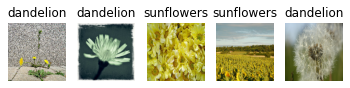

In [4]:
from pathlib import Path
import os
import matplotlib.pyplot as plt

flowers_root = Path(
    tf.keras.utils.get_file(
        "flower_photos",
        "http://download.tensorflow.org/example_images/flower_photos.tgz",
        untar=True,
    )
)

ds = tf.data.Dataset.list_files(str(flowers_root / "*/*"), seed=42)

print("Unprocessed Dataset contents:")
for record in ds.take(5):
    print(record.numpy())
print()

def prepare_data(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    raw_image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(raw_image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

ds = ds.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)

print("Processed Dataset contents:")
f = plt.figure()
n_examples = 5
for idx, (image, label) in enumerate(ds.take(n_examples)):
    ax = f.add_subplot(1, n_examples, idx + 1)
    ax.imshow(image.numpy())
    ax.set_title(label.numpy().decode("utf-8"))
    ax.axis("off")

## Processing Datasets

### Batching

Batching vertically concatenates individual records so that they are ready to be passed to a model in batches for inference.

In [5]:
# Using flowers dataset from previous cell
unbatched_example = next(iter(ds))
print("Shape of unbatched example:", [el.shape for el in unbatched_example])

batched_ds = ds.batch(32)
batched_example = next(iter(batched_ds))
print("Shape of batched example:", [el.shape for el in batched_example])

Shape of unbatched example: [TensorShape([128, 128, 3]), TensorShape([])]
Shape of batched example: [TensorShape([32, 128, 128, 3]), TensorShape([32])]


You can also use `unbatch` to undo batching when presented with a batched dataset.

### Mapping

You have already seen an example above, but `map` can be used to apply the same transformation to each element of a dataset. For example, we can extract just the maximum value of each image in the flowers dataset using the transformation below:

In [6]:
def extract_max_value(image, label):
    return tf.reduce_max(image, axis=(1, 2, 3)), label

mapped_ds = batched_ds.map(extract_max_value, num_parallel_calls=tf.data.AUTOTUNE)

for max_val, label in mapped_ds.take(1):
    print(max_val.numpy())

[1.         0.9943628  0.99944854 0.9593138  0.9385494  1.
 1.         1.         0.98180914 1.         0.99980855 0.99803925
 0.99650735 1.         1.         0.98590696 0.9863628  1.
 0.98116964 0.99954045 1.         0.9420066  1.         0.9505668
 1.         1.         0.99836093 0.99990046 1.         0.9986788
 1.         0.9844976 ]


### Filtering

Can be used to extract elements that satisfy a certain condition. E.g. let's extract only records where the label is dandelion:

In [7]:
dand_ds = ds.filter(lambda image, label: label == "dandelion")

print("Labels found in dandelions-only subset:")
for _, label in dand_ds.take(5):
    print(label.numpy().decode("utf-8"))

Labels found in dandelions-only subset:
dandelion
dandelion
dandelion
dandelion
dandelion


### Etc...

Other things to explore (from the [user guide](https://www.tensorflow.org/guide/data)):
* Using `reduce` on the Dataset.
* Using `tf.py_function` to apply arbitrary python logic (could be slow and subject to GIL?).
* Using `Dataset.window` for windowing (e.g. for time series applications).
* Resampling imbalanced datasets using `tf.data.experimental.sample_from_datasets` or `tf.data.experimental.rejection_resample`.
* Other experimental functions like `tf.data.experimental.unique`.

## Using with Keras

It is straightforward to use datasets with Keras: functions simply assume the dataset contains of features-labels tuples.

In [33]:
# Encode string labels
all_labels = [p.name for p in flowers_root.glob("*") if p.is_dir()]
print("Labels in dataset:", all_labels)

def encode_labels(images, labels):
    ohe_labels = tf.cast(labels[:, tf.newaxis] == all_labels, dtype=tf.int32)
    return images, ohe_labels

# Prepare train and test sets
train_test_size = int(len(ds) * 0.7)
train = (ds.take(train_test_size)
            .batch(128)
            .map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
)
test = (ds.skip(train_test_size)
            .batch(128)
            .map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
)

# Build and train model -- just a linear classifier for demonstration purposes
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(len(all_labels), activation="softmax")
])
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])
history = model.fit(train, epochs=1, validation_data=test)    

Labels in dataset: ['sunflowers', 'daisy', 'roses', 'tulips', 'dandelion']
21/21 [==============================] - 13s 619ms/step - loss: 9.8812 - accuracy: 0.2834 - val_loss: 4.8433 - val_accuracy: 0.4033


## `tensorflow_datasets` package

This is a collection of curated, ready-to-use datasets. For example, let's download MNIST:

In [35]:
import tensorflow_datasets as tfds

mnist_train = tfds.load("mnist", split="train", as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Use `as_supervised` to return the dataset as a images-labels pair, ready for use in a Keras training loop. See the [user guide](https://www.tensorflow.org/datasets/overview) for more on the options available to control how data is downloaded, whether to pre-shuffle the data files, etc.